In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn

from pathlib import Path
from tqdm import tqdm
import gc
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

In [ ]:
import nn4tab

In [ ]:
from nn4tab.model.all import *

ModuleNotFoundError: No module named 'nn4tab.model.all'; 'nn4tab.model' is not a package

# Data

In [ ]:
from nn4tab.data import DataLoader, TabularDataset, get_dsets, cont_cat_split

In [ ]:
df = pd.read_csv('datasets//adult.csv')

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
tmp = df[['education', 'education-num']].groupby('education', as_index=False).agg('mean')

In [ ]:
mgd = df[['education', 'education-num']].merge(tmp, how='left', on='education')
(mgd['education-num_x'] - mgd['education-num_y']).sum()

0.0

In [ ]:
df['education-num'] = mgd['education-num_y']

In [ ]:
del tmp, mgd
gc.collect()

60

In [ ]:
def normalize_numeric_cols(df):
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            df[col] = ((df[col]-df[col].mean())/df[col].std()).astype(np.float32)

In [ ]:
normalize_numeric_cols(df)

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0.763785,Private,-0.838071,Assoc-acdm,0.746028,Married-civ-spouse,NaN,Wife,White,Female,-0.145918,4.503413,-0.035429,United-States,>=50k
1,0.397227,Private,0.444980,Masters,1.523415,Divorced,Exec-managerial,Not-in-family,White,Male,1.278535,-0.216656,0.369514,United-States,>=50k
2,-0.042641,Private,-0.886721,HS-grad,-0.420053,Divorced,NaN,Unmarried,Black,Female,-0.145918,-0.216656,-0.683337,United-States,<50k
3,-0.042641,Self-emp-inc,-0.728862,Prof-school,1.912109,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,-0.145918,-0.216656,-0.035429,United-States,>=50k
4,0.250604,Self-emp-not-inc,-1.018298,7th-8th,-2.363521,Married-civ-spouse,Other-service,Wife,Black,Female,-0.145918,-0.216656,0.774456,United-States,<50k


In [ ]:
def categorify(df):
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            df[col] = df[col].astype('category')

In [ ]:
categorify(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  float32 
 1   workclass       32561 non-null  category
 2   fnlwgt          32561 non-null  float32 
 3   education       32561 non-null  category
 4   education-num   32561 non-null  float32 
 5   marital-status  32561 non-null  category
 6   occupation      32049 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  capital-gain    32561 non-null  float32 
 11  capital-loss    32561 non-null  float32 
 12  hours-per-week  32561 non-null  float32 
 13  native-country  32561 non-null  category
 14  salary          32561 non-null  category
dtypes: category(9), float32(6)
memory usage: 1.0 MB


In [ ]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

In [ ]:
df.occupation.cat.add_categories('#na', inplace=True)
df['occupation'] = df.occupation.fillna('#na')

In [ ]:
def fillna_cat(df):
    pass

In [ ]:
def numericalize_cat_cols(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes

In [ ]:
numericalize_cat_cols(df)

In [ ]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0.763785,4,-0.838071,7,0.746028,2,15,5,4,0,-0.145918,4.503413,-0.035429,39,1
1,0.397227,4,0.444980,12,1.523415,0,4,1,4,1,1.278535,-0.216656,0.369514,39,1
2,-0.042641,4,-0.886721,11,-0.420053,0,15,4,2,0,-0.145918,-0.216656,-0.683337,39,0
3,-0.042641,5,-0.728862,14,1.912109,2,10,0,1,1,-0.145918,-0.216656,-0.035429,39,1
4,0.250604,6,-1.018298,5,-2.363521,2,8,5,2,0,-0.145918,-0.216656,0.774456,39,0


In [ ]:
dep_var = 'salary'
cont, cat = cont_cat_split(df, dep_var)

In [ ]:
cont, cat

(['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

In [ ]:
train_ds, valid_ds = get_dsets(df, cat, cont, [dep_var])

In [ ]:
train_ds[0]

(array([ 4,  9,  4, 12,  1,  4,  1, 39]),
 array([ 0.25060445,  1.3512332 ,  1.1347214 , -0.14591825, -0.2166562 ,
        -0.0354289 ], dtype=float32),
 array([0.], dtype=float32))

In [ ]:
_[0].dtype

dtype('int32')

In [ ]:
from nn4tab.data import get_dl

In [ ]:
train_dl = get_dl(train_ds)
valid_dl = get_dl(valid_ds, train=False)

In [ ]:
x_cat, x_cont, y = next(iter(train_dl))

x_cat.shape, x_cont.shape, y.shape

(torch.Size([512, 8]), torch.Size([512, 6]), torch.Size([512, 1]))

# Model

In [ ]:
from nn4tab.model import TabularModel, get_tabular_model

In [ ]:
# emb_sz = emb_sizes(df, cat)

In [ ]:
# model = TabularModel([100, 50], emb_sz, len(cont), 1, emb_drop=0.1, drops=[0.1,0.2])
# model

In [ ]:
model = get_tabular_model(df, cont, cat, 1, [100, 50])

In [ ]:
x_cat = x_cat.type(torch.long)

In [ ]:
pred = model(x_cat, x_cont)

In [ ]:
pred.shape

torch.Size([512, 1])

In [ ]:
nn.BCEWithLogitsLoss()(pred, y)

tensor(0.7668, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Training

## todo

In [ ]:
for idx, m in enumerate(model.named_modules()):
        print(idx, '->', m)

In [ ]:
do_wd = []
no_wd = []

In [ ]:
for i, m in enumerate(model.modules()):
    print(i)

In [ ]:
for m in model.modules():
    if isinstance(m, nn.BatchNorm1d):
        no_wd += [p for p in m.parameters() if p.requires_grad]
    else:
        do_wd += [p for n, p in m.named_parameters() if ]

In [ ]:
no_wd

In [ ]:
def get_param_groups(model):
    pass

In [ ]:
def weight_decay(p, wd):
    if wd!=0: p.data.mul_(1 - lr*wd)

## Setup

In [ ]:
device = 'cpu'#torch.cuda.current_device()
epochs = 2

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
opt_func = torch.optim.Adam

In [ ]:
optimizer = opt_func([p for p in model.parameters() if p.requires_grad])

## Training loop

In [ ]:
class AverageMeter:
    def __init__(self, store_vals=False, store_avgs=False):
        self.store_vals = store_vals
        if store_vals: self.values = []
        if store_avgs: self.avgs = []
        self.reset()
        
    def update(self, v):
        if self.store_vals: self.values.append(v)
        self.n += 1
        self.sum += v
        self.avg = self.sum/self.n
        
    def reset(self):
        if self.store_avgs and self.avg: self.avgs.append(self.avg)
        self.sum, self.n, self.avg = 0, 0, None

In [ ]:
def accuracy_binary(pred, targ):
    return ((pred>0).float() == targ).float().mean()

In [ ]:
for e in range(epochs):
    
    model.to(device)
    
    train_losses = AverageMeter(True)
    model.train()
    pbar = tqdm(train_dl)
    for x_cat, x_cont, y in pbar:
        x_cat = x_cat.to(device, dtype=torch.long)
        x_cont = x_cont.to(device)
        y = y.to(device)
        
        pred = model(x_cat, x_cont)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        
        train_losses.update(loss.item())
        pbar.set_description(f'epoch {e+1}: train loss {train_losses.avg:.4f}')
    
    
    valid_losses = AverageMeter(True)
    accs = AverageMeter()
    model.eval()
    pbar = tqdm(valid_dl)
    for x_cat, x_cont, y in pbar:
        x_cat = x_cat.to(device, dtype=torch.long)
        x_cont = x_cont.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            pred = model(x_cat, x_cont)
            loss = loss_func(pred, y)
            
        valid_losses.update(loss.item())
        accs.update(accuracy_binary(pred, y).item())
        pbar.set_description(f'epoch {e+1}: valid loss {valid_losses.avg:.4f}, accuracy {accs.avg :.4f}')

epoch 2: valid loss 0.3202, accuracy 0.8543: 100%|█████████████████████| 12/12 [00:11<00:00,  1.06it/s]


## Learner

In [ ]:
%whos

Variable                 Type              Data/Info
----------------------------------------------------
AverageMeter             type              <class '__main__.AverageMeter'>
AveregeMeter             type              <class '__main__.AveregeMeter'>
DataLoader               type              <class 'torch.utils.data.dataloader.DataLoader'>
TabularDataset           type              <class 'nn4tab.data.TabularDataset'>
TabularModel             type              <class 'nn4tab.model.TabularModel'>
acc                      float             0.84375
accs                     AverageMeter      <__main__.AverageMeter ob<...>ct at 0x000002117D864C70>
accuracy_binary          function          <function accuracy_binary at 0x0000021160B40310>
cat                      list              n=8
categorify               function          <function categorify at 0x00000211609A9B80>
cont                     list              n=6
cont_cat_split           function          <function cont_cat_split at

In [ ]:
del loss_func, optimizer, train_dl, valid_dl, pbar, os, x_cat, x_cont, y, opt_func, epochs, e, device
gc.collect()

149

In [ ]:
class Learner:
    
    def __init__(self, model, dataloaders, opt_func, loss_func, metrics=None, use_gpu=True, savepath='./models'):
        
        self.device = 'cuda' if (torch.cuda.is_available() and use_gpu) else 'cpu'
        self.model = model.to(self.device)
        
        self.train_dl = dataloaders[0]
        self.valid_dl = dataloaders[1]
        self.test_dl = dataloaders[2] if len(dataloaders)>2 else None
        
        self.opt_func = opt_func
        self.loss_func = loss_func
        self.metrics = metrics
        
        self.train_losses = AverageMeter(store_vals=True)
        self.valid_losses = AverageMeter(store_avgs=True)
        self.accs = AverageMeter()
#         self.optimizer = opt_func([p for p in self.model.parameters() if p.requires_grad])
        
        self.savepath = Path(savepath)
        self.training = True
        self.epoch = -1
        
    def fit(self, epochs, lr=1e-2):
        self.optimizer = self.opt_func([p for p in self.model.parameters() if p.requires_grad], lr)
        for e in range(epochs):
            self.epoch += 1
            train_loss = self.train()
            
            valid_loss, acc = self.validate()
            
#             print('Train loss = {:f}; valid loss = {:f}; {} = {:f}'.\
#                   format(train_loss, valid_loss, self.metrics.__name__, acc))
            self.save_model()
        
    
    def train(self):
        
        self.train_losses.reset()
        self.model.train()
        pbar = tqdm(self.train_dl)
        for x_cat, x_cont, y in pbar:
            x_cat = x_cat.to(self.device, dtype=torch.long)
            x_cont = x_cont.to(self.device)
            y = y.to(self.device)

            self.optimizer.zero_grad()
            pred = self.model(x_cat, x_cont)
            loss = self.loss_func(pred, y)

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
            self.optimizer.step()

            self.train_losses.update(loss.item())
            pbar.set_description(f'epoch {self.epoch+1}: train loss {train_losses.avg:.4f}')
        return self.train_losses.avg
    
    def validate(self):
        
        self.valid_losses.reset()
        self.accs.reset()
        self.model.eval()
        pbar = tqdm(self.valid_dl)
        for x_cat, x_cont, y in pbar:
            x_cat = x_cat.to(self.device, dtype=torch.long)
            x_cont = x_cont.to(self.device)
            y = y.to(self.device)

            with torch.no_grad():
                pred = self.model(x_cat, x_cont)
                loss = self.loss_func(pred, y)

            self.valid_losses.update(loss.item())
            self.accs.update(accuracy_binary(pred, y).item())
            pbar.set_description(f'epoch {self.epoch+1}: valid loss {self.valid_losses.avg:.4f}, accuracy {self.accs.avg :.4f}')
        
        return self.valid_losses.avg, self.accs.avg
    
    def save_model(self, fn='chkpt_', path=None):
        if not path: path = self.savepath
        fn += str(self.epoch) + '.pt'
        torch.save(self.model.state_dict(), path/fn)
    
    def load_model(self, fn, path=None):
        pass

In [ ]:
learn.model.state_dict()

OrderedDict([('stem.bn.weight',
              tensor([1.2933, 0.9520, 1.1492, 1.3648, 1.0108, 1.1729])),
             ('stem.bn.bias',
              tensor([-0.0004,  0.0002, -0.0028,  0.0023, -0.0012,  0.0005])),
             ('stem.bn.running_mean',
              tensor([-0.0081, -0.0014,  0.0031, -0.0076, -0.0042,  0.0095])),
             ('stem.bn.running_var',
              tensor([0.9876, 0.9588, 1.0003, 0.8907, 0.9780, 0.9599])),
             ('stem.bn.num_batches_tracked', tensor(100)),
             ('stem.embs.0.weight',
              tensor([[-0.0315, -0.0323,  0.0898, -0.0650,  0.0467],
                      [-0.1585, -0.0946,  0.0151,  0.0680,  0.0095],
                      [ 0.0566, -0.1400,  0.0548, -0.0608, -0.0600],
                      [-0.0569,  0.0403, -0.0412, -0.0533,  0.0632],
                      [ 0.0180, -0.0012, -0.0648,  0.0296,  0.0592],
                      [-0.0684, -0.0386, -0.0564,  0.0944, -0.0779],
                      [ 0.1399,  0.1246, -0.0662, 

In [ ]:
def get_dataloaders():
    return get_dl(train_ds), get_dl(valid_ds)

In [ ]:
dataloaders = get_dataloaders()
tab_nn = get_tabular_model(df, cont, cat, 1, [100, 50])

In [ ]:
# learn = Learner(tab_nn, dataloaders, torch.optim.Adam, nn.BCEWithLogitsLoss(), metrics=accuracy_binary)

In [ ]:
learn = Learner(tab_nn, dataloaders,
                torch.optim.Adam, nn.BCEWithLogitsLoss(),
                metrics=accuracy_binary, use_gpu=False)

In [ ]:
learn.fit(2)

epoch 2: valid loss 0.3120, accuracy 0.8532: 100%|█████████████████████| 12/12 [00:11<00:00,  1.03it/s]


In [ ]:
import matplotlib.pyplot as plt

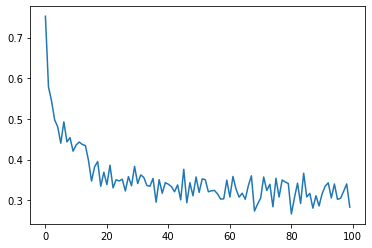

In [ ]:
plt.plot(learn.train_losses.values);

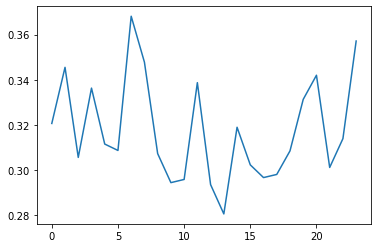

In [ ]:
plt.plot(learn.valid_losses.values)

In [ ]:
def plot_losses(learn):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(learn.train_losses.values)
    vl = [sum(learn.valid_losses.values[:12])/12, sum(learn.valid_losses.values[12:])/12]
    xvl = [(i+1)*len(learn.train_dl) for i in range(learn.epoch+1)]
    plt.plot(xvl, vl)
    ax.set_xlabel('Batches')
    ax.set_ylabel('Loss')
    plt.legend(['Train loss', 'Validation loss'])
    return ax

<AxesSubplot:xlabel='Batches', ylabel='Loss'>

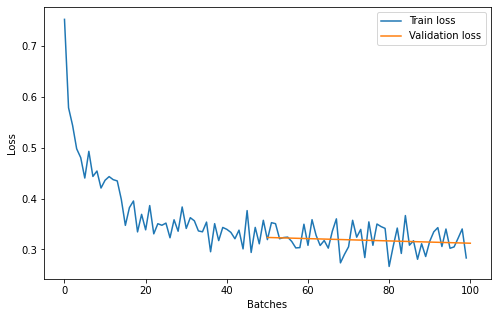

In [ ]:
plot_losses(learn)

Text(0.5, 3.200000000000003, 'batches')